Image Classification Model for _Drosophila_ Embryo Cell Stage Categorization  
By: Noah Rizika  
Intended Use: Bing He Lab

# WORKFLOW OUTLINE

### I. Image Organization and Augmentation

_First upload images to image_upload folder_

A. Remove images before stages 51 and after stages 204

B. Create a folder per stage in **train_every_three** and a folder every third stage in **train_every_nine**

C. Move 15% of images to valid folder
        
    1. Create folders in image_upload (change image_upload to augmented_images folder if applying a filter or mask that isn't just image normalization)

    2. Put corresponding images in those folders  

    3. Move 15% of those images to valid folder's corresponding folder  

D. Feature Engineering / Image Augmentation

4. Extract basic image metadata
    
5. rotate images at 45, 90, 180, 270, 315
    
   (5.5, optional: flip image vertically and horizontally)
    
6. remove or change filter

7. normalize images and save them to normalized_images folder
    
8. convert normalized images into png images and save to png_images folder
    
9. Basic image visualization comparisons of pre and post augmentation

E. Move png images into **train_every_three** folder

F. Move every third folder in **train_every_three** to **train_every_nine** folder

G. Populate train folder by moving images from valid folder

H. Brief Visualizations of Data

H. Upload **train_every_three** and valid folders to S3

### II. Hyperparameter Tuning
A. Run a tuner to get find the best hyperparameters

### III. Model Training
A. Use the tuner's best hyperparameters for the model  

B. Add Rules and Profiler to monitor the model's training

### IV. Model Testing and Analysis
A. Test the model's accuracy and run inferences

In [5]:
# first manually upload images to image_upload folder

In [2]:
import sagemaker
import boto3
import os

In [3]:
# define folder paths
image_upload_path = 'cellImages/image_upload'
augmented_images_path = 'cellImages/working_images/augmented_images'
normalized_images_path = 'cellImages/working_images/normalized_images'
png_images_path = 'cellImages/working_images/png_images'
test_path = 'cellImages/image_data/test'
valid_path = 'cellImages/image_data/valid/'
train_three_min_path = 'cellImages/train_every_three/'
train_nine_min_path = 'cellImages/image_data/train_every_nine/'

In [4]:
# check what is current working directory -- it should be within the cellStageClassifier folder
cwd = os.getcwd()
os.listdir(cwd)

['scripts',
 'Binary_60_96.ipynb',
 '.ipynb_checkpoints',
 'cellImages',
 'hpo.py',
 'Cell_Stage_Classification.ipynb',
 'Stage(060)-20230811-Cycle00-embryo03-3.tif',
 'unchanged_model.ipynb',
 'make_inference.py',
 'train_cellImage_model.py']

In [6]:
# A. remove data from stages before 051 and after 204

for image in os.listdir(image_upload_path):
    if 'Stage' and '.tif' in image:
        image_stage = int(image[6:9])
        image_path = os.path.join(image_upload_path, image)
        if image_stage < 51 or image_stage > 204 or os.path.isfile(image_path) and not 'Stage' in image and not '.tif' in image:
            print('delete: ' + image)
            os.remove(image_path)

In [7]:
# delete both train folders and rerun B and X cells when all data is uploaded to image_upload

# B. make a folder per stage in train_every_three named Stage(xxx)

image_uploads = os.listdir(image_upload_path)
for image in image_uploads:
    if 'Stage' in image and '.png' in image:
        # get train_every_three folder path
        folder_name = image[0:10]
        folder_path = os.path.join(train_three_min_path, folder_name)
    
        # if folder doesn't exist, make folder
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

In [8]:
# B. if training on stages 9 minutes apart, *copy* every other other folders from train_every_three into train_every_nine

import shutil

folders_three_minute = os.listdir(train_three_min_path)
folders_three_minute.sort()

# remove preexisting "train_every_nine" folder
if os.path.isdir(train_nine_min_path):
    shutil.rmtree(train_nine_min_path)

# create the folder
os.mkdir(train_nine_min_path)

# copy every other other folder
for index in range(0, len(folders_three_minute), 3):
    # move a copy into train_every_nine
    folder = folders_three_minute[index]
    source = os.path.join(train_three_min_path, folder)
    destination = os.path.join(train_nine_min_path, folder)
    shutil.copytree(source, destination)

# Move 15% of images for each stage from image_upload into corresponding valid folders

In [8]:
# C. 1) create folders in image_upload and valid

import random

image_upload_folder = os.listdir(image_upload_path)
for image in image_upload_folder:
    if 'Stage' and '.tif' in image:
        # get folders' paths
        folders_name = image[0:10]
        upload_folders_path = os.path.join(image_upload_path, folders_name)
        valid_folders_path = os.path.join(valid_path, folders_name)
    
        # if folder doesn't exist, make folder
        if not os.path.exists(upload_folders_path):
            os.makedirs(upload_folders_path)
        if not os.path.exists(valid_folders_path):
            os.makedirs(valid_folders_path)

In [9]:
# C. 2) put images into each folder in image_upload

import shutil

for image in image_upload_folder:
    image_path = os.path.join(image_upload_path, image)

    # if the image is usable data
    if os.path.isfile(image_path) and 'Stage' and '.tif' in image:
        folder_name = image[0:10]
        folder_path = os.path.join(image_upload_path, folder_name)
        destination = os.path.join(folder_path, image)
        
        # ensure only adding non duplicated images
        if not os.path.exists(destination):
            # track what files were moved and where they went using these two print statements
            # print(file_path)
            # print(destination)
            shutil.move(image_path, destination)
        else:
            print('delete: ' + file_path)
            os.remove(file_path)

In [15]:
# C. 3) move 15% of images in upload_image to corresponding valid folder per stage

image_upload_folder = os.listdir(image_upload_path)
image_upload_folder.sort()

for folder_name in image_upload_folder:
    valid_folder_path = os.path.join(valid_path, folder_name)
    if folder_name == '.ipynb_checkpoints':
        continue
    
    # goal: randomly move 15% of files into corresponding test folder
    
    # repeat (15% of total number of images in folder) number of times:
        # pick a file at random and move it
    folder_in_image_upload_path = os.path.join(image_upload_path, folder_name)
    twenty_percent = int(0.15 * len(os.listdir(folder_in_image_upload_path)))
    for files_moved in range(0, twenty_percent - 1):
        # select random image
        image_upload_dir = os.listdir(folder_in_image_upload_path) # update what is in the folder every time since images are being moved out
        random_index = random.randint(0,len(image_upload_dir) - 1)
        file_to_move = image_upload_dir[random_index]
        
        # ignore if the image is a checkpoint
        if 'checkpoint' in file_to_move:
            files_moved = files_moved - 1
            continue
        
        # get paths
        source = os.path.join(folder_in_image_upload_path, file_to_move)
        destination = os.path.join(valid_folder_path, file_to_move)
        
        # move file into that folder
        shutil.move(source, destination)

In [12]:
# # remove checkpoint files

# image_upload_folders = os.listdir(image_upload_path)
# for folder in image_upload_folders:
#     folder_path = os.path.join(image_upload_path, folder)
#     inside_folder = os.listdir(folder_path)
#     for image in inside_folder:
#         if 'checkpoint' in image:
#             source = os.path.join(folder_path, image)
#             os.remove(source)

In [16]:
# move all images remaining in image_upload to augmented_images folder

image_upload_folders = os.listdir(image_upload_path)
for folder in image_upload_folders:
    folder_path = os.path.join(image_upload_path, folder)
    inside_folder = os.listdir(folder_path)
    for image in inside_folder:
        source = os.path.join(folder_path, image)
        if 'checkpoint' in image:
            os.remove(source)
            continue
        destination = os.path.join(augmented_images_path, image)
        shutil.move(source, destination)

In [45]:
# # remove checkpoint images from augmented_images folder

# augmented_images = os.listdir(augmented_images_path)
# for image in augmented_images:
#     if 'checkpoint' in image:
#         source = os.path.join(augmented_images_path, image)
#         if os.path.isdir(source):
#             os.rmdir(source)
#         if os.path.isfile(source):
#             os.remove(source)

In [6]:
# install for cv2 and imutils

! yes | apt-get update;
! yes | apt-get install libgl1;

! pip install opencv-python;
! pip install --upgrade imutils;

Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Get:2 http://security.debian.org/debian-security buster/updates InRelease [34.8 kB]
Get:3 http://deb.debian.org/debian buster-updates InRelease [56.6 kB]
Get:4 http://security.debian.org/debian-security buster/updates/main amd64 Packages [569 kB]
Get:5 http://deb.debian.org/debian buster/main amd64 Packages [7909 kB]
Get:6 http://deb.debian.org/debian buster-updates/main amd64 Packages [8788 B]
Fetched 8700 kB in 2s (4496 kB/s)
Reading package lists... Done
yes: standard output: Broken pipe
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libdrm-amdgpu1 libdrm-common libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libdrm2 libelf1 libgl1-mesa-dri libglapi-mesa libglvnd0 libglx-mesa0 libglx0
  libllvm7 libpciaccess0 libsensors-config libsensors5 libx11-xcb1
  libxcb-dri2-0 libxcb-dri3-0 libxcb-glx0 libxcb-present0 libxcb-sync1
 

In [7]:
# 4. Extract basic image metadata

from PIL import Image

sample_image = "Stage(060)-20230811-Cycle00-embryo03-3.tif"
image = Image.open(sample_image) # read the image data using PIL

info_dict = {
    "Filename": image.filename,
    "Image Size": image.size,
    "Image Height": image.height,
    "Image Width": image.width,
    "Image Format": image.format,
    "Image Mode": image.mode,
    "Image is Animated": getattr(image, "is_animated", False),
    "Frames in Image": getattr(image, "n_frames", 1)
}

for label,value in info_dict.items():
    print(f"{label:25}: {value}")

Filename                 : Stage(060)-20230811-Cycle00-embryo03-3.tif
Image Size               : (1110, 420)
Image Height             : 420
Image Width              : 1110
Image Format             : TIFF
Image Mode               : RGB
Image is Animated        : False
Frames in Image          : 1


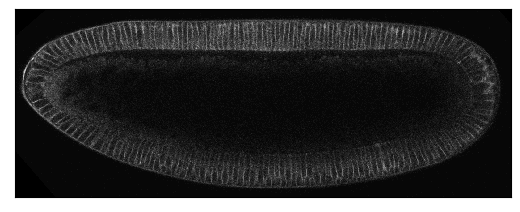

dtype: uint8, shape: (420, 1110, 3), min: 0, max: 217


In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

image_path = 'Stage(060)-20230811-Cycle00-embryo03-3.tif'
img_obj = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
fig = plt.imshow(image)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show()

print(f'dtype: {img_obj.dtype}, shape: {img_obj.shape}, min: {np.min(img_obj)}, max: {np.max(img_obj)}')

In [9]:
# 4. get number of images in each stage

image_count_per_stage = {}
train_nine_min_folders = os.listdir(train_nine_min_path)
train_nine_min_folders.sort()
for folder in train_nine_min_folders:
    count = 0
    train_stage_folder = os.path.join(train_nine_min_path, folder)
    train_stage_image = os.listdir(train_stage_folder)
    for image in train_stage_image:
        if '.png' in image:
            count += 1
    count += 9 # number of images in valid and train
    image_count_per_stage[folder] = count

In [ ]:
# 5. rotate and save images by 45, 90, 180, 270, 315 degrees

import cv2
import matplotlib.pyplot as plt
import imutils

augmented_images = os.listdir(augmented_images_path)
for image in augmented_images:
    if not 'ROTATED' in image and not 'HORIZONTAL' in image and not 'VERTICAL' in image and not 'MULTIPLIED' in image and not 'checkpoint' in image:
        rotations = [45, 90, 180, 270, 315]
        image_path = os.path.join(augmented_images_path, image)
        for degree in rotations:
            # rotate image
            img_obj = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

            # check if image is None, (for debugging.. it shouldn't be None. if it is, ensure correct paths)
            # img_src = cv2.imread(image_path,0)
            # print(img_src)

            rotated = imutils.rotate_bound(img_obj, degree)

            # path to save to
            destination = os.path.join(augmented_images_path, image)
            cv2.imwrite(destination[:-4] + '-ROTATED-' + str(degree) + '.tif', rotated)

In [1]:
# # remove checkpoint images from augmented_images folder

# augmented_images = os.listdir(augmented_images_path)
# for image in augmented_images:
#     if 'checkpoint' in image:
#         source = os.path.join(augmented_images_path, image)
#         if os.path.isfile(source):
#             os.remove(source)
#         if os.path.isdir(source):
#             shutil.rmtree(source)

In [91]:
# # 5.5. flip image vertically and horizontally

# augmented_images = os.listdir(augmented_images_path)
# for image in augmented_images:
#     if not 'ROTATED' in image and not 'HORIZONTAL' in image and not 'VERTICAL' in image and not 'MULTIPLIED' in image and not 'checkpoint' in image:
#         image_path = os.path.join(augmented_images_path, image)

#         img_obj = cv2.imread(image_path, 0) # read input image

#         # vertically flip image (0 is vertical, 1 is horizontal)
#         img_vertical = cv2.flip(img_obj, 0)
#         cv2.imwrite(image_path[:-4] + '-VERTICAL' + '.tif', img_vertical)

#         # horizontally flip image (0 is vertical, 1 is horizontal)
#         img_horizontal = cv2.flip(img_obj, 1)
#         cv2.imwrite(image_path[:-4] + '-HORIZONTAL' + '.tif', img_horizontal)

In [19]:
# 6 - normalize images by multiplying images' pixel channel's by 7
# https://stackoverflow.com/questions/71204415/opencv-python-fastest-way-to-multiply-pixel-value

augmented_images = os.listdir(augmented_images_path)
for image in augmented_images:
    if not 'MULTIPLIED' in image and not 'checkpoint' in image:
        image_path = os.path.join(augmented_images_path, image)
        img_multiplied_tif = cv2.imread(image_path)
        
        # ensure image metadata:
        # print(f'dtype: {img_multiplied_tif.dtype}, shape: {img_multiplied_tif.shape}, min: {np.min(img_multiplied_tif)}, max: {np.max(img_multiplied_tif)}') # expecting uint16
        # dtype: uint8, shape: (420, 1110, 3), min: 0, max: 31 (image changes)
        
        factor = 7

        img_multiplied_tif[...,0] = cv2.multiply(img_multiplied_tif[...,0], factor)
        img_multiplied_tif[...,1] = cv2.multiply(img_multiplied_tif[...,1], factor)
        img_multiplied_tif[...,2] = cv2.multiply(img_multiplied_tif[...,2], factor)

        renamed_image = '/' + image[:-4] + '-MULTIPLIED-7' + '.tif'
        destination = os.path.join(normalized_images_path + renamed_image)
        cv2.imwrite(destination, img_multiplied_tif)
    else:
        print(image)

.ipynb_checkpoints


In [14]:
# 6 - normalize images in valid folder

already_ran = False
if already_ran == False:
    valid_folders = os.listdir(valid_path)
    for folder in valid_folders:
        if not 'checkpoint' in folder:
            valid_folder_path = os.path.join(valid_path, folder)
            valid_folder = os.listdir(valid_folder_path)
        for image in valid_folder:
            if not 'checkpoint' in image:
                image_path = os.path.join(valid_folder_path, image)
                img_multiplied_tif = cv2.imread(image_path)
                # print(f'dtype: {img_multiplied_tif.dtype}, shape: {img_multiplied_tif.shape}, min: {np.min(img_multiplied_tif)}, max: {np.max(img_multiplied_tif)}') # expecting uint16
                # dtype: uint8, shape: (420, 1110, 3), min: 0, max: 31 (image changes)

                r_factor = 7
                g_factor = 7
                b_factor = 7

                img_multiplied_tif[...,0] = cv2.multiply(img_multiplied_tif[...,0], r_factor)
                img_multiplied_tif[...,1] = cv2.multiply(img_multiplied_tif[...,1], g_factor)
                img_multiplied_tif[...,2] = cv2.multiply(img_multiplied_tif[...,2], b_factor)

                # overwrite non-normalized images
                cv2.imwrite(image_path, img_multiplied_tif)
    already_ran = True

In [8]:
# install aspose.words for converting images to png

! pip install aspose-words;

  Obtaining dependency information for aspose-words from https://files.pythonhosted.org/packages/cd/d5/0b52b503abd133d69fea77d7ae06e0f5a657f989278eeab340e5d1d3d757/aspose_words-23.8.0-py3-none-manylinux1_x86_64.whl.metadata
  Using cached aspose_words-23.8.0-py3-none-manylinux1_x86_64.whl.metadata (8.3 kB)
Using cached aspose_words-23.8.0-py3-none-manylinux1_x86_64.whl (82.7 MB)
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [9]:
# 7. convert .tif images in normalized_images folder to .png and place them in png_images folder
# image data for models can only be .png and .jpg images

# if this runs really quickly, then there likely isn't any files for it to convert.
# ->check path's folders

import aspose.words as aw

aspose_image = aw.Document()
builder = aw.DocumentBuilder(aspose_image)

normalized_images = os.listdir(normalized_images_path)
for image in normalized_images:
    if '.tif' in image and not 'checkpoint' in image:
        image_name = image[:-3] + 'png' # rename file to mark its changed image file type
        destination = os.path.join(png_images_path, image_name)
        
        # create png if png image doesn't already exist in destination folder
        if not os.path.exists(destination):
            image_path = os.path.join(normalized_images_path, image)
            shape = builder.insert_image(image_path)
            shape.image_data.save(destination)
    else:
        print('Did not convert to png: ' + image)

Did not convert to png: .ipynb_checkpoints


In [9]:
# convert images in valid folder to .png images

import shutil
import aspose.words as aw

valid_backup_path = 'cellImages/valid_backup'

aspose_image = aw.Document()
builder = aw.DocumentBuilder(aspose_image)

valid_folders = os.listdir(valid_path)
for folder in valid_folders:
    if not 'checkpoint' in folder:
        valid_folder_path = os.path.join(valid_path, folder)
        valid_images = os.listdir(valid_folder_path)
    for image in valid_images:
        if '.tif' in image and not 'checkpoint' in image:
            image_name = image[:-3] + 'png' # rename file to mark its changed image file type
            destination = os.path.join(valid_folder_path, image_name)

            # create png if it doesn't already exist in destination folder
            if not os.path.exists(destination):
                image_path = os.path.join(valid_folder_path, image)
                shape = builder.insert_image(image_path)
                shape.image_data.save(destination)
            else:
                print('Already exists: ' + image)

            # move .tif images to separate folder
            backup_path = os.path.join(valid_backup_path, image)
            shutil.move(image_path, backup_path)

        else:
            print('Did not convert to png: ' + image)

Did not convert to png: Stage(111)-20230815-Cycle00-embryo05-1.png
Did not convert to png: Stage(111)-20230811-Cycle01-embryo03-2.png
Did not convert to png: Stage(111)-20230811-Cycle00-embryo03-1.png
Did not convert to png: Stage(111)-20230815-Cycle01-embryo04-3.png
Did not convert to png: Stage(111)-20230815-Cycle00-embryo02-1.png
Did not convert to png: Stage(111)-20230811-Cycle01-embryo03-3.png
Did not convert to png: Stage(111)-20230810-Cycle01-embryo03-2.png
Did not convert to png: Stage(111)-20230811-Cycle01-embryo01-3.png
Did not convert to png: Stage(111)-20230815-Cycle01-embryo05-3.png
Did not convert to png: Stage(201)-20230815-Cycle01-embryo04-1.png
Did not convert to png: Stage(201)-20230811-Cycle01-embryo01-1.png
Did not convert to png: Stage(201)-20230810-Cycle01-embryo02-3.png
Did not convert to png: Stage(120)-20230810-Cycle01-embryo05-1.png
Did not convert to png: Stage(120)-20230811-Cycle01-embryo04-3.png
Did not convert to png: Stage(120)-20230815-Cycle01-embryo04-2

In [2]:
# # remove hidden checkpoints folder and its files

# checkpoint_path = os.path.join(augmented_images_path, '.ipynb_checkpoints')
# if os.isdir(checkpoint_path):
    # for image in os.listdir(checkpoint_path):
    #     image_path = checkpoint_path + image
    #     print('delete image: ' + image_path)
    #     os.remove(image_path)
    # print('delete folder: ' + checkpoint_path)
    # os.rmdir(checkpoint_path)

In [10]:
# for specific use cases:

# # delete both train folders and rerun B and X cells when all data is uploaded to image_upload
# # make a folder per stage in train_every_three named Stage(xxx)

# image_uploads = os.listdir(image_upload_path)
# for image in image_uploads:
#     if 'Stage' in image and '.png' in image:
#         # get train_every_three folder path
#         folder_name = image[:10]
#         folder_path = os.path.join(train_three_min_path, folder_name)
    
#         # if folder doesn't exist, make folder
#         if not os.path.exists(folder_path):
#             os.makedirs(folder_path)

In [11]:
# E. move images from png into corresponding train_every_three folder

png_images = os.listdir(png_images_path)
for image in png_images:
    if 'checkpoint' in image:
        continue

    if 'Stage' in image and '.png' in image:
        image_path = os.path.join(png_images_path, image)
        folder_name = image[:10]
        destination = os.path.join(train_three_min_path, folder_name)

        # make folder if it doesn't exist
        if not os.path.exists(destination):
            os.makedirs(destination)

        shutil.move(image_path, destination)

In [31]:
# F. *copy* every other other folders (including their images) from train_every_three into train_every_nine

import shutil

folders_three_minute = os.listdir(train_three_min_path)
folders_three_minute.sort()

# delete checkpoint folder
for folder in folders_three_minute:
    if 'checkpoint' in folder:
        folders_three_minute.remove('.ipynb_checkpoints')

# remove preexisting "train_every_nine" folder
if os.path.isdir(train_nine_min_path):
    shutil.rmtree(train_nine_min_path)

# create the folder
os.mkdir(train_nine_min_path)

# copy every other other folder
for index in range(0, len(folders_three_minute), 3):
    # move a copy into train_every_nine
    folder = folders_three_minute[index]
    source = os.path.join(train_three_min_path, folder)
    destination = os.path.join(train_nine_min_path, folder)
    shutil.copytree(source, destination)

['Stage(051)', 'Stage(054)', 'Stage(057)', 'Stage(060)', 'Stage(063)', 'Stage(066)', 'Stage(069)', 'Stage(072)', 'Stage(075)', 'Stage(078)', 'Stage(081)', 'Stage(084)', 'Stage(087)', 'Stage(090)', 'Stage(093)', 'Stage(096)', 'Stage(099)', 'Stage(102)', 'Stage(105)', 'Stage(108)', 'Stage(111)', 'Stage(114)', 'Stage(117)', 'Stage(120)', 'Stage(123)', 'Stage(126)', 'Stage(129)', 'Stage(132)', 'Stage(135)', 'Stage(138)', 'Stage(141)', 'Stage(144)', 'Stage(147)', 'Stage(150)', 'Stage(153)', 'Stage(156)', 'Stage(159)', 'Stage(162)', 'Stage(165)', 'Stage(168)', 'Stage(171)', 'Stage(174)', 'Stage(177)', 'Stage(180)', 'Stage(183)', 'Stage(186)', 'Stage(189)', 'Stage(192)', 'Stage(195)', 'Stage(198)', 'Stage(201)', 'Stage(204)']


In [9]:
# G. move one image per stage in valid to corresponding folder in test (run this cell twice)

import random
import shutil
import os

valid_folders = os.listdir(valid_path)
valid_folders.sort()
for folder in valid_folders:
    if folder == '.ipynb_checkpoints':
        continue
    images_in_a_valid_folder_path = os.path.join(valid_path, folder)
    for files_moved in range(0, 1):
        # select random image
        valid_dir = os.listdir(images_in_a_valid_folder_path) # update what is in the folder every time since images are being moved out
        random_index = random.randint(0,len(valid_dir) - 1)
        file_to_move = valid_dir[random_index]
        
        # ignore if the image is a checkpoint
        if 'checkpoint' in file_to_move:
            files_moved = files_moved - 1
            continue
        
        # get paths
        source = os.path.join(images_in_a_valid_folder_path, file_to_move)
        destination = os.path.join(test_path, file_to_move)
        
        # move file into that folder
        shutil.move(source, destination)

In [13]:
# # for specific use cases:
# # if needed, move all images from valid back into image_upload

# valid_folders = os.listdir(valid_path)
# for folder in valid_folders:
#     folder_path = os.path.join(valid_path, folder)
#     valid_images = os.listdir(folder_path)
#     for image in valid_images:
#         source = os.path.join(folder_path, image)
#         destination = os.path.join(image_upload_path, folder)
#         shutil.move(source, destination)

In [10]:
# 4. get non augmented image count per stage

# formula for non augmented image count: number of unique images = (train images / 6) + 9 (the number of unique images in valid and test)
non_aug_image_count_per_stage = {}
for stage, count in image_count_per_stage.items():
    count -= 9
    count /= 6
    count += 9
    non_aug_image_count_per_stage[stage] = count
    
print (non_aug_image_count_per_stage)

{'Stage(051)': 69.0, 'Stage(060)': 69.0, 'Stage(069)': 69.0, 'Stage(078)': 69.0, 'Stage(087)': 69.0, 'Stage(096)': 69.0, 'Stage(105)': 69.0, 'Stage(114)': 69.0, 'Stage(123)': 69.0, 'Stage(132)': 69.0, 'Stage(141)': 69.0, 'Stage(150)': 69.0, 'Stage(159)': 69.0, 'Stage(168)': 69.0, 'Stage(177)': 69.0, 'Stage(186)': 69.0, 'Stage(195)': 44.0, 'Stage(204)': 39.0}


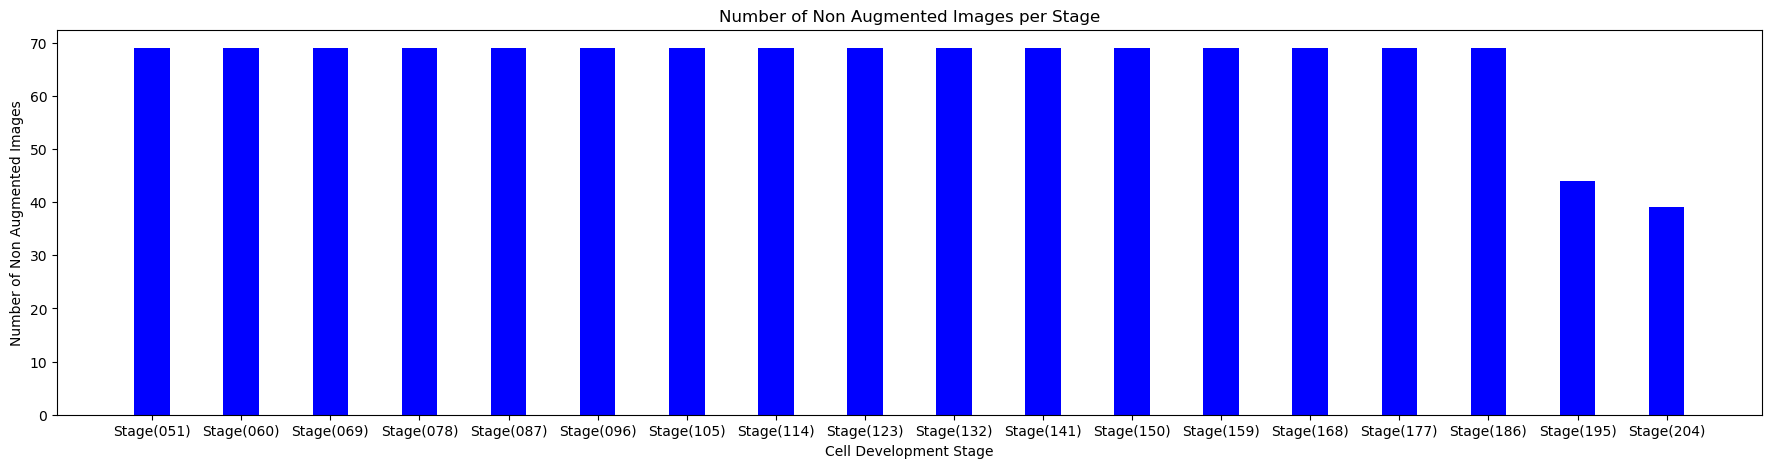

In [45]:
# 4. create a bar chart of the number of images per stage before augmentation

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

stages = list(non_aug_image_count_per_stage.keys())
count = list(non_aug_image_count_per_stage.values())
fig = plt.figure(figsize = (22, 5))
 
# creating the bar plot
plt.bar(stages, count, color ='blue',
        width = 0.4)
 
plt.xlabel("Cell Development Stage")
plt.ylabel("Number of Non Augmented Images")
plt.title("Number of Non Augmented Images per Stage")
plt.show()

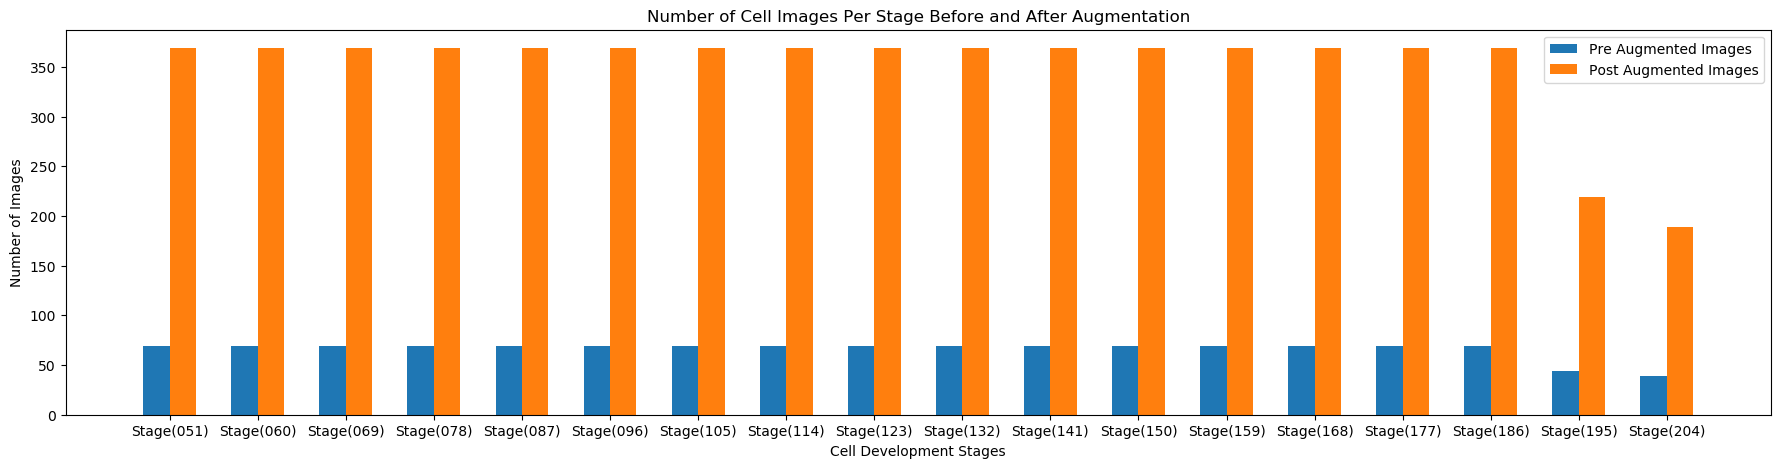

In [54]:
# Numbers of pairs of bars you want
N = len(non_aug_image_count_per_stage)

# Data on X-axis

# Specify the values of blue bars (height)
pre_aug_image_count = non_aug_image_count_per_stage.values()
# Specify the values of orange bars (height)
post_aug_image_count = image_count_per_stage.values()

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(22,5))

# Width of a bar 
width = 0.3

# Plotting
plt.bar(ind, pre_aug_image_count , width, label='Pre Augmented Images')
plt.bar(ind + width, post_aug_image_count, width, label='Post Augmented Images')

plt.xlabel('Cell Development Stages')
plt.ylabel('Number of Images')
plt.title('Number of Cell Images Per Stage Before and After Augmentation')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
# plt.xticks(ind + width / 2, ('Xtick1', 'Xtick3', 'Xtick3'))
plt.xticks(ind + width / 2, (non_aug_image_count_per_stage.keys()))


# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()

In [51]:
# 9. Extract post augmentation image metadata

from PIL import Image
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

sample_image = "cellImages/image_data/train_every_nine/Stage(114)/Stage(114)-20230810-Cycle01-embryo01-1-ROTATED-180-MULTIPLIED-7.png"
image = Image.open(sample_image) # read the image data using PIL

post_info_dict = {
    "Filename": image.filename,
    "Image Size": image.size,
    "Image Height": image.height,
    "Image Width": image.width,
    "Image Format": image.format,
    "Image Mode": image.mode,
    "Image is Animated": getattr(image, "is_animated", False),
    "Frames in Image": getattr(image, "n_frames", 1)
}

for label,value in info_dict.items():
    print(f"{label:25}: {value}")

Filename                 : cellImages/image_data/train_every_nine/Stage(114)/Stage(114)-20230810-Cycle01-embryo01-1-ROTATED-180-MULTIPLIED-7.png
Image Size               : (1110, 420)
Image Height             : 420
Image Width              : 1110
Image Format             : PNG
Image Mode               : RGBA
Image is Animated        : False
Frames in Image          : 1


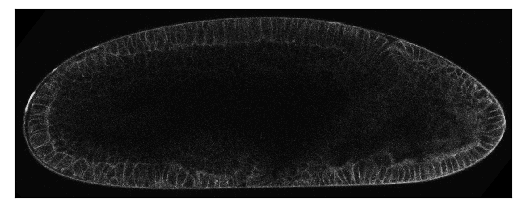

dtype: uint8, shape: (420, 1110, 4), min: 0, max: 255


In [49]:
# 9. Extract post augmentation image metadata

import cv2
import matplotlib.pyplot as plt
import numpy as np

image_path = "cellImages/image_data/train_every_nine/Stage(114)/Stage(114)-20230810-Cycle01-embryo01-1-ROTATED-180-MULTIPLIED-7.png"
img_obj = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
fig = plt.imshow(image)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show()

print(f'dtype: {img_obj.dtype}, shape: {img_obj.shape}, min: {np.min(img_obj)}, max: {np.max(img_obj)}')

# Upload to S3

In [30]:
import os
import shutil

session = sagemaker.Session()
bucket = session.default_bucket()
key_prefix = 'cell_data'
region = 'us-east-1'

role = sagemaker.get_execution_role()

In [48]:
# delete any 'checkpoint' file or folder in train_every_nine and valid folders

train_nine_min_folders = os.listdir(train_nine_min_path)
for folder in train_nine_min_folders:
    if 'checkpoint' in folder:
        checkpoint_image_path = os.path.join(train_nine_min_path, image)
        os.rmdir(checkpoint_image_path)

valid_folders = os.listdir(valid_path)
for folder in valid_folders:
    if 'checkpoint' in folder:
        checkpoint_image_path = os.path.join(valid_path, folder)
        os.rmdir(checkpoint_image_path)

test_folders = os.listdir(test_path)
for folder in test_folders:
    if 'checkpoint' in folder:
        checkpoint_image_path = os.path.join(test_path, folder)
        os.rmdir(checkpoint_image_path)

In [ ]:
# check image dimensions for abnormalities

image_data_path = 'cellImages/image_data'
train_data_folders = os.listdir(image_data_path)
for train_or_valid_or_test in train_data_folders:
    one_of_three_folders = os.path.join(image_data_path, train_or_valid_or_test)
    train_folders = os.listdir(one_of_three_folders)
    train_folders.sort()
    for folder in train_folders:
        train_images_in_folder_path = os.path.join(one_of_three_folders, folder)
        train_images = os.listdir(train_images_in_folder_path)
        for image in train_images:
            if 'checkpoint' in image:
                continue
            individual_image_path = os.path.join(train_images_in_folder_path, image)
            img_obj = Image.open(filepath)
            
            # get width and height
            width = img_obj.width
            height = img_obj.height
            if width > 1110 or width < 1110:
                print(individual_image_path + '\'s width: ' + width)
            if height > 420 or height < 420:
                print(individual_image_path + '\'s height: ' + height)
            # else:
                # print images that were not uploaded
                # print(individual_image_path)

In [33]:
# create a test folder per stage

test_images = os.listdir(test_path)
for image in test_images:
    if 'Stage' and '.png' in image:
        # get folders' paths
        folders_name = image[0:10]
        test_folder_path = os.path.join(test_path, folders_name)
    
        # if folder doesn't exist, make folder
        if not os.path.exists(test_folder_path):
            os.makedirs(test_folder_path)

In [ ]:
# put test images into each folder in test folder

import shutil

test_images = os.listdir(test_path)

for image in test_images:
    image_path = os.path.join(test_path, image)

    # if the image is usable data
    if os.path.isfile(image_path) and 'Stage' and '.png' in image:
        folder_name = image[0:10]
        folder_path = os.path.join(test_path, folder_name)
        destination = os.path.join(folder_path, image)
        
        # ensure only adding non duplicated images
        if not os.path.exists(destination):
            print(destination)
            # track what files were moved and where they went using these two print statements
            # print(file_path)
            # print(destination)
            shutil.move(image_path, destination)
        else:
            print('delete: ' + file_path)
            os.remove(file_path)

In [32]:
# upload image data to S3

import logging
import boto3
from botocore.exceptions import ClientError
import os

s3 = boto3.client('s3', region_name=region)

try:
    image_data_path = 'cellImages/image_data'
    train_data_folders = os.listdir(image_data_path)
    for train_or_valid_or_test in train_data_folders:
        one_of_three_folders = os.path.join(image_data_path, train_or_valid_or_test)
        train_folders = os.listdir(one_of_three_folders)
        train_folders.sort()
        if 'train' in train_or_valid_or_test:
            continue
        for folder in train_folders:
            train_images_in_folder_path = os.path.join(one_of_three_folders, folder)
            train_images = os.listdir(train_images_in_folder_path)
            for image in train_images:
                if 'checkpoint' in image:
                    continue
                individual_image_data = os.path.join(train_images_in_folder_path, image)
                upload_bucket = 'sagemaker-us-east-1-726671190186'

                # Upload the file
                s3_client = boto3.client('s3')
                response = s3_client.upload_file(individual_image_data, upload_bucket, individual_image_data)
                # print("Upload successful")
except ClientError as e:
    print("Upload failed: ", e)

# Hyperparameter Tuning

_tuning and training scripts were in large part taken from jakpor on github: https://github.com/jakpor/Udacity-AWS-ML-project-3/blob/master/train_and_deploy.ipynb_

In [29]:
import sagemaker
import os

session = sagemaker.Session()
bucket = session.default_bucket()
key_prefix = 'cellImages/image_data'
region = 'us-east-1'

role = sagemaker.get_execution_role()

In [30]:
# Declare HP ranges and metrics
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{
    "Name": "Test Loss",
    "Regex": "Testing Loss: ([0-9\\.]+)"
}]

hyperparameter_ranges = {
    "learning_rate": sagemaker.tuner.ContinuousParameter(0.001, 0.1),
    "batch-size": sagemaker.tuner.CategoricalParameter([32, 64, 128, 256, 512]),
    "epochs": sagemaker.tuner.CategoricalParameter([2, 3, 4])
}

In [31]:
# Create estimator
from sagemaker.pytorch import PyTorch
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.xlarge" # (Need at least this large of an instance. Otherwise, 'ClientError')
)

In [32]:
# Create tuner
tuner = sagemaker.tuner.HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [33]:
os.environ["SM_CHANNEL_TRAINING"] = "s3://" + bucket + "/cellImages/image_data/"
os.environ['SM_MODEL_DIR'] = "s3://" + bucket + "/cellImages/models/" # where model will be stored

In [34]:
tuner.fit({"training": "s3://" + bucket + "/cellImages/image_data/"}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-230906-2327


Using provided s3_resource
.................................................................................................................................!


### Different Tuners' Performances for Generating Hyperperameters

#### hpo_for_tuner.py best training job: 'pytorch-training-230905-0426-002-8bda5a12'
{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"128"',
 'learning_rate': '0.006976346186102541',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-09-05-04-26-23-286"',
 'sagemaker_program': '"hpo_for_tuner.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-726671190186/pytorch-training-2023-09-05-04-26-23-286/source/sourcedir.tar.gz"'}

#### hpo.py best training job: 'pytorch-training-230906-2113-002-3ef7c772'
{'_tuning_objective_metric': '"Test Loss"',
 'batch-size': '"32"',
 'learning_rate': '0.014488941353736724',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-09-06-23-27-53-419"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-726671190186/pytorch-training-2023-09-06-23-27-53-419/source/sourcedir.tar.gz"'}

In [37]:
# Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

# Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-09-06 23:38:03 Starting - Found matching resource for reuse
2023-09-06 23:38:03 Downloading - Downloading input data
2023-09-06 23:38:03 Training - Training image download completed. Training in progress.
2023-09-06 23:38:03 Uploading - Uploading generated training model
2023-09-06 23:38:03 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"Test Loss"',
 'batch-size': '"32"',
 'learning_rate': '0.014488941353736724',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-09-06-23-27-53-419"',
 'sagemaker_program': '"hpo_try_two.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-726671190186/pytorch-training-2023-09-06-23-27-53-419/source/sourcedir.tar.gz"'}

In [36]:
tuner.best_training_job()

'pytorch-training-230906-2327-003-1b6c210c'

# Create Model

In [54]:
# https://sagemaker-examples.readthedocs.io/en/latest/sagemaker-debugger/tensorflow_builtin_rule/tf-mnist-builtin-rule.html

import sys
import IPython
install_needed = True  # Set to True to upgrade
if install_needed:
    print("installing deps and restarting kernel")
    !{sys.executable} -m pip install -U sagemaker
    !{sys.executable} -m pip install -U smdebug
    IPython.Application.instance().kernel.do_shutdown(True)

installing deps and restarting kernel
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 10.3 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for urllib3<1.27,>=1.25.4 from https://files.pythonhosted.org/packages/c5/05/c214b32d21c0b465506f95c4f28ccbcba15022e000b043b72b3df7728471/urllib3-1.26.16-py2.py3-none-any.whl.metadata
  Using cached urllib3-1.26.16-py2.py3-none-any.whl.metadata (48 kB)
Using cached urllib3-1.26.16-py2.py3-none-any.whl (143 kB)
  Created wheel for sagemaker: filename=sagemaker-2.183.0-py2.py3-none-any.whl size=1185519 sha256=2369b9363c46a78c8e5cd866e99b3457feba21b5e20521cceb0ef81c2c462db7
  Stored in directory: /root/.cache/pip/wheels/64/b9/97/1af9132f8d296f0df5a083145c82698bd404ebe8f046e39805
Successfully built sagemaker
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or c

In [ ]:
import sagemaker
import os

In [6]:
session = sagemaker.Session()
bucket = session.default_bucket()
key_prefix = 'cellImages/image_data'
region = 'us-east-1'

role = sagemaker.get_execution_role()

In [7]:
hyperparameters = {
    "learning_rate": 0.006976346186102541,
    "batch-size": 128,
}

In [8]:
import sagemaker
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.xlarge",
    entry_point="train_cellImage_model.py",
    framework_version="1.8",
    py_version='py36',
    hyperparameters=hyperparameters,
)

### Add rules and profiler

In [9]:
# Set up debugging rules and hooks

from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [10]:
# Set up profiling rules

from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

debugger_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [11]:
os.environ["SM_CHANNEL_TRAINING"] = "s3://" + bucket + "/cellImages/image_data/"
os.environ['SM_MODEL_DIR'] = "s3://" + bucket + "/cellImages/model/" # where model will be stored

In [12]:
estimator.fit({"training": "s3://" + bucket + "/cellImages/image_data/"}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-09-06-22-59-42-049


Using provided s3_resource
2023-09-06 22:59:42 Starting - Starting the training job...
2023-09-06 22:59:58 Starting - Preparing the instances for training......
2023-09-06 23:00:57 Downloading - Downloading input data......
2023-09-06 23:02:12 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-09-06 23:02:23,266 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-09-06 23:02:23,269 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-09-06 23:02:23,278 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-09-06 23:02:23,281 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-09-06 23:02:23,443 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-09-06 23:02:23,458 sagemake

train_cellImage_model.py name: 'pytorch-training-2023-09-06-22-59-42-049'

In [13]:
estimator._current_job_name

'pytorch-training-2023-09-06-22-59-42-049'

# Deploy Model

In [56]:
import sagemaker
import os

session = sagemaker.Session()
bucket = session.default_bucket()
key_prefix = 'cellImages/image_data'
region = 'us-east-1'

role = sagemaker.get_execution_role()

In [57]:
# create ImagePredictor - without it the Image function won't be able to decode bytes
from sagemaker.predictor import Predictor
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/png")
json_deserializer = sagemaker.deserializers.JSONDeserializer

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer
        )

In [58]:
# model_location = estimator.model_data
model_location = 's3://sagemaker-us-east-1-726671190186/pytorch-training-2023-09-06-22-59-42-049/output/model.tar.gz'

print(model_location)

s3://sagemaker-us-east-1-726671190186/pytorch-training-2023-09-06-22-59-42-049/output/model.tar.gz


In [59]:
from sagemaker.pytorch import PyTorchModel

role = sagemaker.get_execution_role()

pytorch_model = PyTorchModel(model_data=model_location, 
                             role=role, 
                             entry_point='make_inference.py',
                             py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

In [60]:
# Create an endpoint using trained model
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

-----!

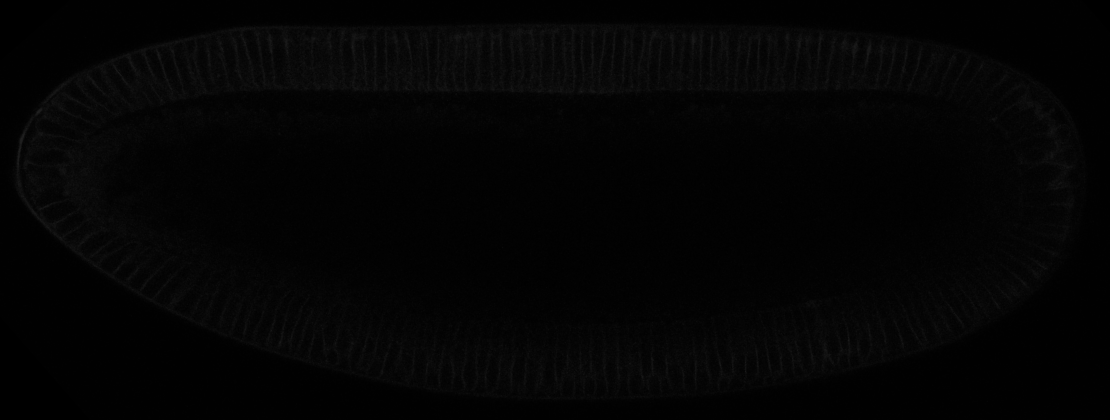

In [17]:
# TIFF IMAGE

import io
from PIL import Image
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

byteImgIO = io.BytesIO()
byteImg = Image.open('cellImages/unchanged/unchanged_backup/Stage(060)/Stage(060)-20230811-Cycle00-embryo03-3.tif')

byteImg.save(byteImgIO, "PNG") #change to PNG if not work
byteImgIO.seek(0)
byteImg = byteImgIO.read()

# Non test code
dataBytesIO = io.BytesIO(byteImg)
Image.open(dataBytesIO)

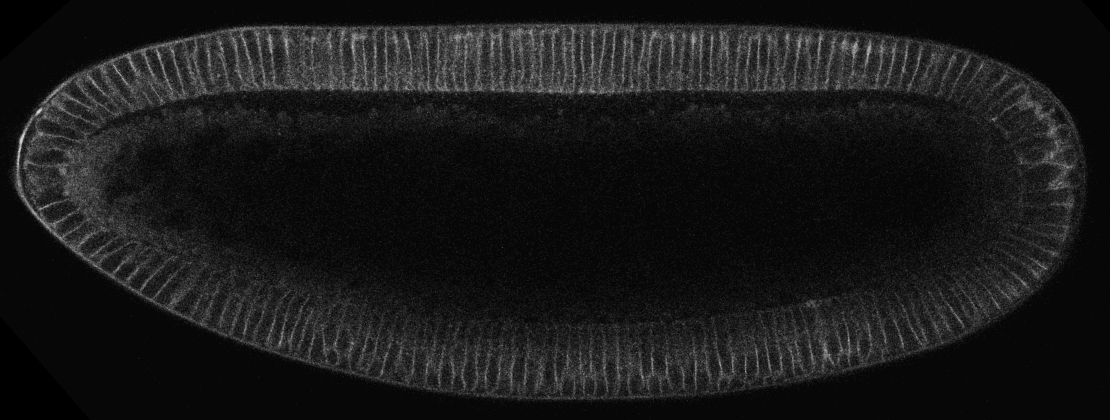

In [61]:
from PIL import Image
from PIL import ImageFile
import io

ImageFile.LOAD_TRUNCATED_IMAGES = True

byteImgIO = io.BytesIO()
# byteImg = Image.open("cellImages/valid_backup/Stage(096)-20230815-Cycle00-embryo05-3.tif")
byteImg = Image.open("cellImages/valid_backup/Stage(060)-20230811-Cycle00-embryo03-3.tif")

byteImg.save(byteImgIO, "PNG")
byteImgIO.seek(0)
byteImg = byteImgIO.read()


# Non test code
dataBytesIO = io.BytesIO(byteImg)
Image.open(dataBytesIO)

In [69]:
from sagemaker.predictor import RealTimePredictor

# Endpoint name found in AWS -> SageMaker -> Endpoints
endpoint = 'pytorch-inference-2023-11-18-00-29-40-267'

# Read image into memory    
with open("cellImages/working_images/normalized_images/Stage(099)-20230811-Cycle01-embryo02-1-MULTIPLIED-7.tif", "rb") as image:
    f = image.read()
    img_bytes = bytearray(f)

In [70]:
# https://stackoverflow.com/questions/77108320/typeerror-can-only-join-an-iterable-testing-invoking-a-sagemaker-endpoint-for
# https://docs.aws.amazon.com/sagemaker/latest/dg/neo-requests-sdk.html

predictor = Predictor(endpoint)
inference_response = predictor.predict(data=img_bytes, initial_args={"ContentType": "image/png"})

In [76]:
# save response below for quick analysis

print(inference_response)
type(inference_response)

b'[[0.09491108357906342, -1.0061631202697754, -0.19999873638153076, -0.15245486795902252, 0.32159844040870667, 0.5776973962783813, -0.07733944803476334, -0.4804781377315521, -0.3675159811973572, 1.9144656658172607, 0.029580695554614067, -0.6238042712211609, -0.6338831186294556, -0.5787041783332825, 0.23752766847610474, -0.40100035071372986, -0.10914292186498642]]'


bytes

In [116]:
# copy and paste responses to convert from byte array to array (this is the simplest and most reliable solution I could find)

response = [0.09491108357906342, -1.0061631202697754, -0.19999873638153076, -0.15245486795902252, 0.32159844040870667, 0.5776973962783813, -0.07733944803476334, -0.4804781377315521, -0.3675159811973572, 1.9144656658172607, 0.029580695554614067, -0.6238042712211609, -0.6338831186294556, -0.5787041783332825, 0.23752766847610474, -0.40100035071372986, -0.10914292186498642]

In [117]:
print("Raw prediction result:")
print(response)
print()

labeled_predictions = list(zip(range(51), response))
# labeled_predictions = list(zip(range(17), inference_response))
print("Labeled predictions: ")
print(labeled_predictions)
print()

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))
print()

print("Labeled predictions sorted: ")
print(labeled_predictions)
print()

Raw prediction result:
[0.09491108357906342, -1.0061631202697754, -0.19999873638153076, -0.15245486795902252, 0.32159844040870667, 0.5776973962783813, -0.07733944803476334, -0.4804781377315521, -0.3675159811973572, 1.9144656658172607, 0.029580695554614067, -0.6238042712211609, -0.6338831186294556, -0.5787041783332825, 0.23752766847610474, -0.40100035071372986, -0.10914292186498642]

Labeled predictions: 
[(0, 0.09491108357906342), (1, -1.0061631202697754), (2, -0.19999873638153076), (3, -0.15245486795902252), (4, 0.32159844040870667), (5, 0.5776973962783813), (6, -0.07733944803476334), (7, -0.4804781377315521), (8, -0.3675159811973572), (9, 1.9144656658172607), (10, 0.029580695554614067), (11, -0.6238042712211609), (12, -0.6338831186294556), (13, -0.5787041783332825), (14, 0.23752766847610474), (15, -0.40100035071372986), (16, -0.10914292186498642)]

Most likely answer: (9, 1.9144656658172607)

Labeled predictions sorted: 
[(9, 1.9144656658172607), (5, 0.5776973962783813), (4, 0.321598

In [118]:
# convert answer to stage

first_answer = labeled_predictions[0]
second_answer = labeled_predictions[1]
third_answer = labeled_predictions[2]

first_answer_stage = 51 + (first_answer[0] * 9)
second_answer_stage = 51 + (second_answer[0] * 9)
third_answer_stage = 51 + (third_answer[0] * 9)

print('The cell\'s most likely stage: {}'.format(first_answer_stage))
print('The cell\'s second most likely stage: {}'.format(second_answer_stage))
print('The cell\'s third most likely stage: {}'.format(third_answer_stage))
print()


first_answer_confidence = first_answer[1]
second_answer_confidence = second_answer[1]
third_answer_confidence = third_answer[1]

# difference in confidence between 1 and 2, 2 and 3, 3 and 4
print('Rounded confidence difference between...')
print('1st and 2nd most likely predictions: {:.3f}'.format(first_answer_confidence - second_answer_confidence))
print('2nd and 3rd most likely predictions: {:.3f}'.format(second_answer_confidence - third_answer_confidence))
print('3rd and 4th most likely predictions: {:.3f}'.format(third_answer_confidence - labeled_predictions[3][1]))
print('Small decimal value = similar likelihoods')
print('Large decimal value = former prediction is more likely than the latter')

The cell's most likely stage: 132
The cell's second most likely stage: 96
The cell's third most likely stage: 87

Rounded confidence difference between...
1st and 2nd most likely predictions: 1.337
2nd and 3rd most likely predictions: 0.256
3rd and 4th most likely predictions: 0.084
Small decimal value = similar likelihoods
Large decimal value = former prediction is more likely than the latter


In [119]:
# print a table of all predicted stages with its confidence in order of confidence
import pandas as pd

timepoints = []
confidence_rankings = []

for prediction in labeled_predictions:
    timepoints.append(51 + (prediction[0] * 9))
    confidence_rankings.append(prediction[1])

d = {'Timepoint (min)': timepoints, 'Confidence Ranking': confidence_rankings}
df = pd.DataFrame(data=d)

# print the table
df

,Timepoint (min),Confidence Ranking
0,132,1.914466
1,96,0.577697
2,87,0.321598
3,177,0.237528
4,51,0.094911
5,141,0.029581
6,105,-0.077339
7,195,-0.109143
8,78,-0.152455
9,69,-0.199999


### Calculate Accuracy of Model

In [126]:
# Get accuracy if top three predicitons are considered correct

from PIL import Image
import io

test_folders = os.listdir(test_path)
correct = 0
total = 0
for folder in test_folders:
    folder_path = os.path.join(test_path, folder)
    test_folder = os.listdir(folder_path)
    for image in test_folder:
        if '.png' in image: #try doing png images too tho
            # get image name in test but don't include the .png
            image_name = image[:-3] + 'tif'
            
            # get image path from valid_backup but using test's image name
            image_path = 'cellImages/valid_backup/' + image_name
            
            with open("cellImages/working_images/normalized_images/Stage(099)-20230811-Cycle01-embryo02-1-MULTIPLIED-7.tif", "rb") as prediction_image:
                f = prediction_image.read()
                img_bytes = bytearray(f)
            
            response=predictor.predict(byteImg, initial_args={"ContentType": "image/png"})
            
            # see if correct prediction is in the top three
            labeled_predictions = list(zip(range(51), response))
            labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
            
            top_six = [labeled_predictions[0][0], labeled_predictions[1][0], labeled_predictions[2][0], labeled_predictions[3][0], labeled_predictions[4][0], labeled_predictions[5][0]]
            
            stage_converted = int(image[6:9])
            stage_converted = (stage_converted - 51) / 9
            
            if stage_converted in top_six:
                correct += 1
            total += 1

In [75]:
print(str(correct) + '/' + str(total))
print('accuracy: {}%'.format(correct/total))

20/36
accuracy: 0.5555555555555556%


In [128]:
# Delete endpoint before closing AWS

predictor.delete_endpoint()